# import all needed dependencies

In [1]:
import numpy as np
import pandas as pd
from keras import models, layers, metrics
import matplotlib.pyplot as plt
import seaborn as sns

# data preperation

In [2]:
df_train = pd.read_csv('../churn_prediction_data/train.csv')

## take a look at the data

In [3]:
df_train.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,551,15806307,Trevisano,720,Spain,Male,38,5,114051.97,2,0,1,107577.29,0
1,6897,15709621,Martin,682,France,Female,54,4,62397.41,1,1,0,113088.60,1
2,4588,15619340,Palmer,672,France,Female,31,5,119903.67,1,1,1,132925.17,0


In [4]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
df_train['Geography'] = lbl.fit_transform(df_train['Geography'].astype(str))
df_train['Gender'] = lbl.fit_transform(df_train['Gender'].astype(str))

In [5]:
#df_train['Gender'] = df_train['Gender'].replace({'Male': 0, 'Female': 1})
#df_train.drop('Geography', inplace=True, axis=1)

## heatmap on features of train & test data

Text(0.5, 1.0, 'x_train')

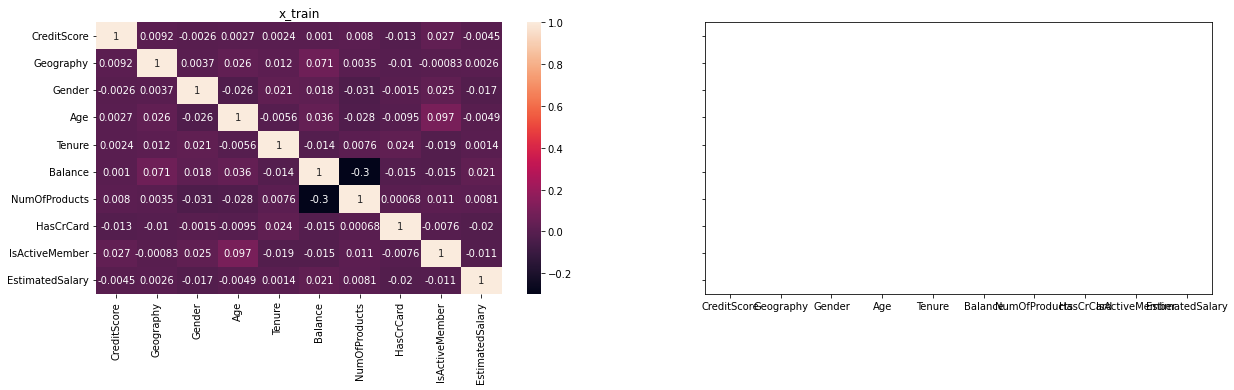

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)
#fig.suptitle('')

train_data = df_train.loc[:, 'CreditScore': 'EstimatedSalary']

sns.heatmap(train_data.corr(), ax=axes[0], annot=True)
axes[0].set_title('x_train')

## checking label distribution on training data

In [8]:
print(df_train.Exited.unique())
print(df_train.Exited.value_counts())

[0 1]
0    6368
1    1632
Name: Exited, dtype: int64


###### (must be careful on imbalance label)

## x-y preperation

In [9]:
train_data = df_train.loc[:, 'CreditScore': 'EstimatedSalary']
train_label = df_train['Exited']

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size = 0.25, random_state = 48)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_standardized = scaler.fit_transform(x_train)
x_test_standardized = scaler.transform(x_test)

In [12]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [13]:
y_train.shape, y_test.shape

((6000, 2), (2000, 2))

In [14]:
x_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
82,542,0,0,44,3,62397.41,2,1,0,71012.75
7150,631,2,1,42,3,62397.41,3,1,0,85994.11
4900,689,0,1,41,5,133969.11,1,1,1,139697.67
2228,643,0,0,49,5,122594.60,1,0,1,85570.47
4488,711,0,1,36,6,62397.41,2,0,0,130631.04
...,...,...,...,...,...,...,...,...,...,...
3860,671,0,1,37,6,117472.16,2,1,1,79397.91
1644,572,2,0,32,3,62397.41,2,0,1,141578.81
7954,569,0,0,31,5,132308.54,1,1,0,112700.04
5437,614,2,1,47,3,104277.57,1,0,1,91856.46


In [15]:
y_test[1]

array([0., 1.], dtype=float32)

## model training

In [16]:
import tensorflow_addons as tfa
METRICS = [
    'accuracy', 
    metrics.Precision(name='precision', thresholds=0.7), 
    tfa.metrics.F1Score(num_classes=2)
]

2021-12-03 02:29:05.948464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
from keras import regularizers
number_of_features = x_train_standardized.shape[1]

network = models.Sequential()
network.add(layers.Dense(units=9, activation='relu', input_dim=number_of_features))
network.add(layers.Dense(units=18, activation='relu'))
network.add(layers.Dense(units=18, activation='relu', kernel_regularizer=regularizers.l2(0.01))) #kernel_regularizer=regularizers.l2(0.01)
network.add(layers.Dense(units=9, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
network.add(layers.Dense(units=9, activation='relu'))
network.add(layers.Dense(units=2, activation='sigmoid'))

network.compile(
    loss='binary_crossentropy', 
    optimizer='rmsprop', 
    metrics=METRICS)

network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 99        
_________________________________________________________________
dense_1 (Dense)              (None, 18)                180       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 20        
Total params: 902
Trainable params: 902
Non-trainable params: 0
__________________________________________________________

In [18]:
history = network.fit(
    x_train_standardized, 
    y_train, 
    epochs=150, 
    verbose=1, 
    batch_size=50, # -> 6000/50
    validation_data=(x_test_standardized, y_test)
    )

2021-12-03 02:29:06.088173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
120/120 [==============================] - 1s 4ms/step - loss: 0.8044 - accuracy: 0.7452 - precision: 0.8449 - f1_score: 0.4931 - val_loss: 0.6166 - val_accuracy: 0.8070 - val_precision: 0.8459 - val_f1_score: 0.4466
Epoch 2/150
120/120 [==============================] - 0s 1ms/step - loss: 0.5682 - accuracy: 0.7923 - precision: 0.8286 - f1_score: 0.4421 - val_loss: 0.5021 - val_accuracy: 0.8070 - val_precision: 0.8527 - val_f1_score: 0.4466
Epoch 3/150
120/120 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.7923 - precision: 0.8480 - f1_score: 0.4421 - val_loss: 0.4625 - val_accuracy: 0.8070 - val_precision: 0.8708 - val_f1_score: 0.4466
Epoch 4/150
120/120 [==============================] - 0s 1ms/step - loss: 0.4712 - accuracy: 0.7923 - precision: 0.8584 - f1_score: 0.4421 - val_loss: 0.4481 - val_accuracy: 0.8070 - val_precision: 0.8719 - val_f1_score: 0.4466
Epoch 5/150
120/120 [==============================] - 0s 1ms/step - loss: 0.4604 - 

In [19]:
network_result = network.evaluate(x_test_standardized, y_test, batch_size=10, verbose=1)
for name, value in zip(network.metrics_names, network_result):
    print(name, ':', value)

200/200 [==============================] - 0s 973us/step - loss: 0.3362 - accuracy: 0.8690 - precision: 0.9003 - f1_score: 0.7526
loss : 0.33618026971817017
accuracy : 0.8690000176429749
precision : 0.9002848863601685
f1_score : [0.9223013  0.58280253]


In [20]:
final = (network_result[1] + network_result[2] + sum(network_result[3])/2) / 3
final

0.8406122724215189

## model evaluation

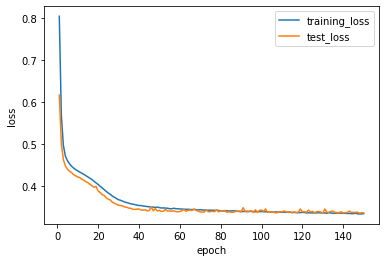

In [21]:
training_loss = history.history['loss']
test_loss  = history.history['val_loss']
epoch_count = range(1, len(training_loss)+1)
plt.plot(epoch_count, training_loss)
plt.plot(epoch_count, test_loss)
plt.legend(['training_loss', 'test_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

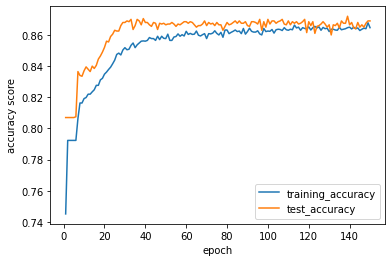

In [22]:
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
plt.plot(epoch_count, training_accuracy)
plt.plot(epoch_count, test_accuracy)
plt.legend(['training_accuracy', 'test_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy score')
plt.show()

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_f1_score'])

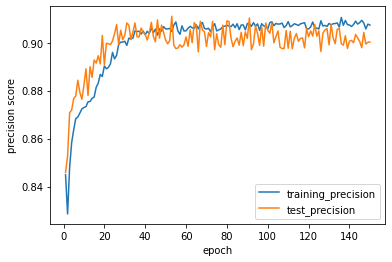

In [24]:
plt.plot(epoch_count, history.history['precision'])
plt.plot(epoch_count, history.history['val_precision'])
plt.legend(['training_precision', 'test_precision'])
plt.xlabel('epoch')
plt.ylabel('precision score')
plt.show()

In [25]:
predictions = network.predict(x_test_standardized)
predictions

array([[0.90712965, 0.09254628],
       [0.8256679 , 0.17521957],
       [0.9713521 , 0.02806774],
       ...,
       [0.9008671 , 0.0988777 ],
       [0.80497146, 0.19638842],
       [0.8756263 , 0.12444651]], dtype=float32)

In [26]:
predictions_label = np.argmax(network.predict(x_test_standardized), axis=1)
assert len(predictions_label) == 2000
predictions_label

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
count_1 = 0
count_0 = 0
for ans1, ans2 in zip(predictions_label, np.argmax(y_test, axis=1)):
    if ans1 == 1 and ans2 == 1:
        count_1 += 1
    elif ans1 == 0 and ans2 == 0:
        count_0 += 1
print((count_1+count_0)/2000)

0.869


In [28]:
predictions_label[1]

0

In [29]:
np.argmax(y_test, axis=1)[1]

1

# output result on `test.csv`

In [30]:
df_test = pd.read_csv('../churn_prediction_data/test.csv')
df_test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,2209,15623595,Scott,726,France,Female,39,3,62397.41,1,0,0,106139.31
1,9924,15740283,Yegorova,661,France,Male,42,3,130339.64,1,1,0,125776.38
2,4617,15802368,Tan,545,France,Male,34,6,62397.41,2,1,1,78372.28
3,6077,15615322,Anayochukwu,731,Spain,Female,42,3,86717.08,1,1,0,136026.27
4,9240,15766374,Glover,533,France,Female,50,6,62397.41,1,1,1,135205.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7872,15617348,Taylor,628,France,Male,35,6,62397.41,2,1,1,96201.09
1996,4257,15642785,Tokareva,639,Germany,Male,41,5,98154.30,2,1,0,109531.64
1997,2273,15766575,Trevisan,548,France,Female,46,3,119078.34,2,1,1,116725.67
1998,315,15610271,Dickson,602,Spain,Female,44,7,62397.41,2,1,1,128135.95


In [31]:
lbl = preprocessing.LabelEncoder()
df_test['Geography'] = lbl.fit_transform(df_test['Geography'].astype(str))
df_test['Gender'] = lbl.fit_transform(df_test['Gender'].astype(str))

In [32]:
#df_test['Gender'] = df_test['Gender'].replace({'Male': 0, 'Female': 1})
#df_test.drop('Geography', inplace=True, axis=1)
x_hat_test = df_test.loc[:, 'CreditScore': 'EstimatedSalary']
x_hat_test_standardized = scaler.transform(x_hat_test)

In [33]:
y_hat_predictions_label = np.argmax(network.predict(x_hat_test_standardized), axis=1)
y_hat_predictions_label

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
df_upload = pd.DataFrame({
    'RowNumber': list(df_test.RowNumber), 
    'Exited': y_hat_predictions_label
})
df_upload

,RowNumber,Exited
0,2209,0
1,9924,0
2,4617,0
3,6077,0
4,9240,1
...,...,...
1995,7872,0
1996,4257,0
1997,2273,0
1998,315,0


In [35]:
df_upload.to_csv('../churn_prediction_data/DNN.csv')